We install the brainscapes library, and set an EBRAINS Knowledge Graph authentication token the we can request  [here](https://nexus-iam.humanbrainproject.org/v0/oauth2/authorize) after creating an HBP account.

In [1]:
!pip install brainscapes
from os import environ
environ['HBP_AUTH_TOKEN'] = "<<<Paste your HBP auth token here>>>"

zsh:1: command not found: pip


# Instantiate human brain atlas with Julich-Brain cytoarchitectonic maps

We instantiate the human atlas, and tell it to prefer thresholded continous maps over labelled regions in the discrete parcellation map. For the Julich-Brain parcellation, this mean that it will use thresholded probability maps, if available.

In [1]:
import brainscapes as bs
bs.logger.setLevel("INFO") # we want to see some messages!

In [2]:
atlas = bs.atlases.MULTILEVEL_HUMAN_ATLAS

# next line is optional - cytoarchitectonic maps are selected by default
atlas.select_parcellation(bs.parcellations.JULICH_BRAIN_PROBABILISTIC_CYTOARCHITECTONIC_MAPS_V2_5_)

# as in the original JuGEx, we prefer thresholded probability maps 
# over the labelled region in the maximum probability map
atlas.enable_continuous_map_thresholding(0.2)

[brainscapes:INFO]  Selected parcellation "Julich-Brain Probabilistic Cytoarchitectonic Maps (v2.5)"


# Instantiate a differential gene expression analysis with this atlas

The analysis object will check if the parcellation selected in the atlas is suitable for the analysis. What it does in fact, is to verify that it provides maps in the MNI ICBM 152 space. We add a few candidate genes that we're interested in. They could also be added right away as a list to the constructor in the first line below. Then we select two regions of interest (ROI) by specifying brain area names that the atlas can interpret.

In [3]:
candidate_regions = ["v1 right","v2 right"]
candidate_genes = ["MAOA","TAC1"]

In [4]:
jugex = bs.analysis.DifferentialGeneExpression(atlas)
# NOTE: you can lookup and autocomplete gene names from bs.features_gene_names
for gene_name in candidate_genes:
    jugex.add_candidate_gene(gene_name)
jugex.define_roi1(candidate_regions[0])
jugex.define_roi2(candidate_regions[1])

[brainscapes:INFO]  Selected region Area hOc1 (V1, 17, CalcS) - right hemisphere
[brainscapes:INFO]  Retrieving probe ids for gene TAC1
[brainscapes:INFO]  Using continuous map thresholded by 0.2 for masking region Area hOc1 (V1, 17, CalcS) - right hemisphere.
[brainscapes:INFO]  Retrieving probe ids for gene MAOA
[brainscapes:INFO]  12 samples found for region v1 right.
[brainscapes:INFO]  Selected region Area hOc2 (V2, 18) - right hemisphere
[brainscapes:INFO]  Retrieving probe ids for gene TAC1
[brainscapes:INFO]  Using continuous map thresholded by 0.2 for masking region Area hOc2 (V2, 18) - right hemisphere.
[brainscapes:INFO]  Retrieving probe ids for gene MAOA
[brainscapes:INFO]  11 samples found for region v2 right.


# Look at the positions of the samples

Let's have a look at the sample positions that have been found in the Allen atlas. Since we configured brainscapes to prefer thresholded continuous maps for region filtering over the simplified parcellation map, we also plot the probability maps here.

[brainscapes:INFO]  Selected region Area hOc1 (V1, 17, CalcS) - right hemisphere
[brainscapes:INFO]  Selected region Area hOc2 (V2, 18) - right hemisphere


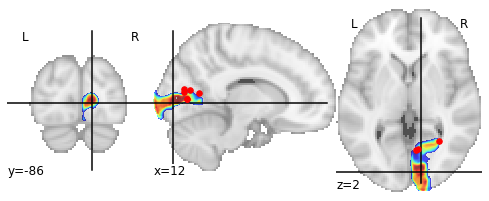

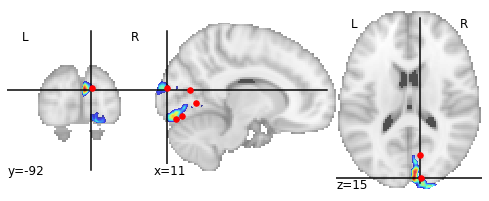

In [13]:
from nilearn import plotting
import numpy as np

for region in candidate_regions:
    samples = jugex.get_samples(region)
    atlas.select_region(region)
    pmap = atlas.selected_region.get_specific_map(
        bs.spaces.MNI_152_ICBM_2009C_NONLINEAR_ASYMMETRIC)    
    # we could have also used the simple parcellation map mask as follows:
    # mask = atlas.get_mask(bs.spaces.MNI_152_ICBM_2009C_NONLINEAR_ASYMMETRIC)

    display = plotting.plot_roi(pmap,cmap='jet')
    display.add_markers([s['mnicoord'] for s in samples.values()])

# Run the analysis

We are now setup to run the analysis.

In [14]:
jugex.run(permutations=1000,random_seed=42)
print(jugex.result)

[brainscapes:INFO]  Using random seed 42.
[brainscapes:INFO]  Running 1000 random permutations. This may take a while...


{'TAC1': 0.425, 'MAOA': 0.958}


The aggregated input parameters can be stored to disk.

In [15]:
jugex.save_inputs('jugex_inputs_{}_{}.json'.format(
    "_".join(candidate_regions),
    "_".join(candidate_genes) ))

[brainscapes:INFO]  Exported input factors to file jugex_inputs_v1 right_v2 right_MAOA_TAC1.json.
